In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split

In [3]:
# Define transformations (normalize images)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load dataset
train_data = torchvision.datasets.FashionMNIST(root="./data", train=True, transform=transform, download=True)
test_data = torchvision.datasets.FashionMNIST(root="./data", train=False, transform=transform, download=True)

# Split dataset
train_set, val_set = random_split(train_data, [50000, 10000])  # 50k train, 10k validation
train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
val_loader = DataLoader(val_set, batch_size=64, shuffle=False)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)


In [4]:
class CNN(nn.Module):
    def __init__(self, dropout_rate=0.5):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)
        self.dropout = nn.Dropout(dropout_rate)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


In [5]:
def train_model(model, criterion, optimizer, train_loader, val_loader, epochs=10, device="cpu"):
    model.to(device)
    best_val_loss = float('inf')

    for epoch in range(epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_acc = 100. * correct / total

        # Validation
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = outputs.max(1)
                val_total += labels.size(0)
                val_correct += predicted.eq(labels).sum().item()

        val_loss /= len(val_loader)
        val_acc = 100. * val_correct / val_total

        print(f"Epoch {epoch+1}/{epochs}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), "best_model.pth")

    print("Training Complete!")


In [8]:
import optuna

def objective(trial):
    # Suggest hyperparameters
    lr = trial.suggest_loguniform("lr", 1e-4, 1e-2)
    dropout_rate = trial.suggest_uniform("dropout_rate", 0.2, 0.6)
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "SGD", "RMSprop"])

    # Define model
    model = CNN(dropout_rate=dropout_rate)
    criterion = nn.CrossEntropyLoss()
    optimizer = getattr(optim, optimizer_name)(model.parameters(), lr=lr)

    # Train model
    train_model(model, criterion, optimizer, train_loader, val_loader, epochs=5, device="cpu")

    # Load best model
    model.load_state_dict(torch.load("best_model.pth"))
    model.eval()

    # Evaluate on validation set
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            outputs = model(images)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    val_acc = 100. * correct / total
    return val_acc  # Return validation accuracy

# Run Optuna optimization
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10)

# Print best parameters
print("Best hyperparameters:", study.best_params)


C:\Users\sunny\.conda\envs\torch_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2025-03-11 17:40:18,596] A new study created in memory with name: no-name-f7c2bf5c-582a-4096-915f-5a47ecc5e5d5
C:\Users\sunny\AppData\Local\Temp\ipykernel_24396\1530223845.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-4, 1e-2)
C:\Users\sunny\AppData\Local\Temp\ipykernel_24396\1530223845.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform("dropout_ra

Epoch 1/5: Train Loss: 2.2775, Train Acc: 19.52% | Val Loss: 2.2491, Val Acc: 33.49%
Epoch 2/5: Train Loss: 2.2170, Train Acc: 35.47% | Val Loss: 2.1771, Val Acc: 43.96%
Epoch 3/5: Train Loss: 2.1173, Train Acc: 45.11% | Val Loss: 2.0391, Val Acc: 52.43%
Epoch 4/5: Train Loss: 1.9334, Train Acc: 52.28% | Val Loss: 1.7937, Val Acc: 58.71%
Epoch 5/5: Train Loss: 1.6453, Train Acc: 56.80% | Val Loss: 1.4571, Val Acc: 63.33%
Training Complete!


C:\Users\sunny\AppData\Local\Temp\ipykernel_24396\1530223845.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pth"))
[I 2025

Epoch 1/5: Train Loss: 1.4259, Train Acc: 52.30% | Val Loss: 0.7132, Val Acc: 74.69%
Epoch 2/5: Train Loss: 0.7255, Train Acc: 73.58% | Val Loss: 0.6008, Val Acc: 77.20%
Epoch 3/5: Train Loss: 0.6352, Train Acc: 76.75% | Val Loss: 0.5181, Val Acc: 81.17%
Epoch 4/5: Train Loss: 0.5861, Train Acc: 78.49% | Val Loss: 0.5001, Val Acc: 81.52%
Epoch 5/5: Train Loss: 0.5529, Train Acc: 79.83% | Val Loss: 0.4668, Val Acc: 82.78%
Training Complete!


[I 2025-03-11 17:47:56,194] Trial 1 finished with value: 82.78 and parameters: {'lr': 0.006160924376341004, 'dropout_rate': 0.5659598202300493, 'optimizer': 'SGD'}. Best is trial 1 with value: 82.78.


Epoch 1/5: Train Loss: 0.5400, Train Acc: 80.31% | Val Loss: 0.3611, Val Acc: 86.64%
Epoch 2/5: Train Loss: 0.3949, Train Acc: 85.28% | Val Loss: 0.3643, Val Acc: 86.83%
Epoch 3/5: Train Loss: 0.3668, Train Acc: 86.53% | Val Loss: 0.3599, Val Acc: 86.50%
Epoch 4/5: Train Loss: 0.3533, Train Acc: 86.96% | Val Loss: 0.3419, Val Acc: 87.89%
Epoch 5/5: Train Loss: 0.3464, Train Acc: 87.16% | Val Loss: 0.3369, Val Acc: 87.72%
Training Complete!


[I 2025-03-11 17:52:16,444] Trial 2 finished with value: 87.72 and parameters: {'lr': 0.009738339498340179, 'dropout_rate': 0.23799122913731563, 'optimizer': 'Adam'}. Best is trial 2 with value: 87.72.


Epoch 1/5: Train Loss: 0.4828, Train Acc: 82.53% | Val Loss: 0.3157, Val Acc: 88.44%
Epoch 2/5: Train Loss: 0.3252, Train Acc: 88.22% | Val Loss: 0.2726, Val Acc: 89.99%
Epoch 3/5: Train Loss: 0.2816, Train Acc: 89.75% | Val Loss: 0.2603, Val Acc: 90.45%
Epoch 4/5: Train Loss: 0.2526, Train Acc: 90.66% | Val Loss: 0.2723, Val Acc: 90.22%
Epoch 5/5: Train Loss: 0.2330, Train Acc: 91.28% | Val Loss: 0.2534, Val Acc: 91.09%
Training Complete!


[I 2025-03-11 17:54:07,426] Trial 3 finished with value: 91.09 and parameters: {'lr': 0.0034220823701358195, 'dropout_rate': 0.3990629600450678, 'optimizer': 'Adam'}. Best is trial 3 with value: 91.09.


Epoch 1/5: Train Loss: 0.6143, Train Acc: 78.01% | Val Loss: 0.3845, Val Acc: 85.65%
Epoch 2/5: Train Loss: 0.4087, Train Acc: 85.52% | Val Loss: 0.3213, Val Acc: 88.57%
Epoch 3/5: Train Loss: 0.3588, Train Acc: 87.39% | Val Loss: 0.2983, Val Acc: 89.32%
Epoch 4/5: Train Loss: 0.3306, Train Acc: 88.29% | Val Loss: 0.2756, Val Acc: 90.15%
Epoch 5/5: Train Loss: 0.3034, Train Acc: 89.21% | Val Loss: 0.2741, Val Acc: 90.54%
Training Complete!


[I 2025-03-11 17:55:46,782] Trial 4 finished with value: 90.54 and parameters: {'lr': 0.00098504244766309, 'dropout_rate': 0.5629365675388052, 'optimizer': 'RMSprop'}. Best is trial 3 with value: 91.09.


Epoch 1/5: Train Loss: 2.1195, Train Acc: 34.00% | Val Loss: 1.7588, Val Acc: 60.57%
Epoch 2/5: Train Loss: 1.3921, Train Acc: 54.08% | Val Loss: 0.9938, Val Acc: 71.18%
Epoch 3/5: Train Loss: 0.9755, Train Acc: 65.70% | Val Loss: 0.7655, Val Acc: 74.03%
Epoch 4/5: Train Loss: 0.8163, Train Acc: 70.87% | Val Loss: 0.6776, Val Acc: 76.29%
Epoch 5/5: Train Loss: 0.7358, Train Acc: 73.52% | Val Loss: 0.6273, Val Acc: 77.36%
Training Complete!


[I 2025-03-11 17:57:21,856] Trial 5 finished with value: 77.36 and parameters: {'lr': 0.0014468903337504575, 'dropout_rate': 0.5290762482720848, 'optimizer': 'SGD'}. Best is trial 3 with value: 91.09.


Epoch 1/5: Train Loss: 1.0876, Train Acc: 77.59% | Val Loss: 0.4541, Val Acc: 82.84%
Epoch 2/5: Train Loss: 0.4416, Train Acc: 84.45% | Val Loss: 0.3774, Val Acc: 86.19%
Epoch 3/5: Train Loss: 0.3676, Train Acc: 86.63% | Val Loss: 0.3597, Val Acc: 86.76%
Epoch 4/5: Train Loss: 0.3400, Train Acc: 87.49% | Val Loss: 0.3215, Val Acc: 88.48%
Epoch 5/5: Train Loss: 0.3203, Train Acc: 88.39% | Val Loss: 0.3329, Val Acc: 88.21%
Training Complete!


[I 2025-03-11 17:58:59,134] Trial 6 finished with value: 88.48 and parameters: {'lr': 0.00546964745610484, 'dropout_rate': 0.27068980324027564, 'optimizer': 'RMSprop'}. Best is trial 3 with value: 91.09.
[W 2025-03-11 17:59:11,680] Trial 7 failed with parameters: {'lr': 0.0011665630310384496, 'dropout_rate': 0.5232671987516175, 'optimizer': 'SGD'} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "C:\Users\sunny\.conda\envs\torch_env\lib\site-packages\optuna\study\_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\sunny\AppData\Local\Temp\ipykernel_24396\1530223845.py", line 15, in objective
    train_model(model, criterion, optimizer, train_loader, val_loader, epochs=5, device="cpu")
  File "C:\Users\sunny\AppData\Local\Temp\ipykernel_24396\897317410.py", line 15, in train_model
    loss.backward()
  File "C:\Users\sunny\.conda\envs\torch_env\lib\site-packages\torch\_tensor.py", line 521, in backward
 

KeyboardInterrupt: 

C:\Users\sunny\AppData\Local\Temp\ipykernel_24396\169590649.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load("best_model.pth"))


Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.84      0.82      1000
           1       0.99      0.95      0.97      1000
           2       0.83      0.82      0.83      1000
           3       0.87      0.87      0.87      1000
           4       0.81      0.75      0.78      1000
           5       0.98      0.94      0.96      1000
           6       0.65      0.69      0.67      1000
           7       0.93      0.95      0.94      1000
           8       0.98      0.98      0.98      1000
           9       0.94      0.96      0.95      1000

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



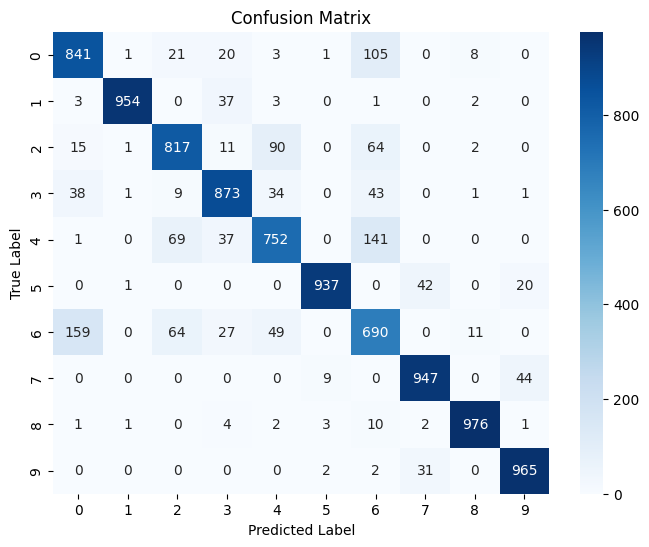

In [9]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate_model(model, test_loader):
    model.eval()
    y_true, y_pred = [], []

    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            _, predicted = outputs.max(1)
            y_true.extend(labels.numpy())
            y_pred.extend(predicted.numpy())

    print("Classification Report:\n", classification_report(y_true, y_pred))

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

# Load best model and evaluate
best_model = CNN()
best_model.load_state_dict(torch.load("best_model.pth"))
evaluate_model(best_model, test_loader)
